# Group 12 - Robo Advising:
- Team Number: <font color="gold"> 12 </font>
- Team Member Names: <font color="gold"> Robin Zhang, Jessica Chen, Eric Wang </font>
- Team Strategy Chosen: <font color="red"> Risky </font>

In [232]:
# import libraries
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import threading

## Background: 

Usually in portfolio management, we assume that investors are __risk-averse__; if there is higher risk, they will expect a higher return. Most strategies taught in class center on this idea and try to minimize risk for some return or maximize return for some risk. 

__Variance__, or its __square root__, __standard deviation__, can be used to quantify risk. With more variable returns, the spread of a stock’s return from the mean is larger, leading to a larger standard deviation. The more diversified a portfolio is, the lower the risk. This is because holding multiple securities can mitigate the effect of fluctuations in price of a single stock on the overall portfolio.  

__Beta__ captures a stock’s riskiness in relation to the market, this is not entirely what we are aiming to achieve. We want to find the riskiest stock overall, thus variance or standard deviation are better at encapsulating overall risk.

__Sharpe Ratio__ adjusts the end return based on risk. We decided that Sharpe Ratio will be inconclusive for our portfolio strategy because only the end return matters and are not interested in adjusting our portfolio based on its risk. 

In [233]:
# All subsequent data retrieval will use the given dates
start_date = "2021-11-25"
end_date = "2022-11-25"

We chose the data range to be within a year to avoid past extraneous circumstances that are no longer applicable to our current analysis. For example, if we include data from 2020, we would have included data from a period of extreme uncertainty which might not reflect the regular movement of the stock. 

In [234]:
def filter(filename):
    #Call the CSV file and store it in a dataframe
    tickers = pd.read_csv(filename)

    #Clean the the dataframe
    colname = tickers.columns[0]

    #rename tickers columns and create missing_data dataframe
    tickers.columns = ['Tickers']
    missing_data = pd.DataFrame({'Tickers': [colname]})

    #append the two dataframes
    tickers = pd.concat([missing_data, tickers])

    tickers.reset_index(inplace=True, drop=True)
    #make list of tickers
    ticker_list = list(tickers.Tickers)

    #set the start and end dates for the filter
    start_date_filter = '2022-01-01'
    end_date_filter = '2022-10-01'
    #empty series to hold volume of tickers
    ticker_data = {}
    #empty list to temporarily hold the sorted tickers
    new_lst = []

    def checkTicker(ticker):
        #get the historical data for the ticker
        firm = yf.Ticker(ticker)
        firm_hist = firm.history(start=start_date_filter, end=end_date_filter, interval='1mo')
        firm_hist.reset_index(inplace=True)

        #filter and remove rows that do not have at least 20 business days
        for x in range(len(firm_hist)-1):
            #x should 
            first_month = firm_hist.iloc[x, 0].strftime('%Y-%m-%d')
            next_month = firm_hist.iloc[x+1, 0].strftime('%Y-%m-%d')
            if np.busday_count(first_month, next_month) < 20:
                #drop the row of hist
                firm_hist.drop([x, 0])


        ticker_data[t] = firm_hist.Volume

        if ticker_data[t].mean() >= 200000:
            #make a new lst that stores the values where mean >200 000
            #return that list
            new_lst.append(ticker)
    
    Threads=[]
    
    for ticker in ticker_list:
        # start a thread t each time we call t
        t = threading.Thread(target=checkTicker, args=[ticker])
        t.start()
        # Puts them into a list so can join() later
        Threads.append(t)

    for thread in Threads:
        # join the threads together to run concurrently
        thread.join()
    
    ticker_list = new_lst
    #remove all tickers not listed on US market
    #by deleting all values with a "." in them
    for t in ticker_list:
        if "." in t:
            ticker_list.remove(t)

    return ticker_list

In [235]:
ticker_list = filter('Tickers_Example.csv')
print(ticker_list)

- AGN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted
['ABT', 'BAC', 'ABBV', 'BLK', 'BK', 'CMCSA', 'BA', 'AIG', 'BIIB', 'BMY', 'LLY', 'AXP', 'GM', 'CSCO', 'C', 'GOOG', 'AAPL', 'ACN', 'CL', 'CVS', 'AMZN', 'COF', 'CAT', 'JPM', 'KMI', 'COST', 'COP', 'MON', 'MO', 'KO', 'PYPL', 'MSFT', 'ORCL', 'NKE', 'NEE', 'LMT', 'QCOM', 'MRK', 'PG', 'PEP', 'OXY', 'MS', 'PM', 'SBUX', 'PFE', 'SPG', 'TGT', 'T', 'TXN', 'UPS', 'USB', 'UNH', 'SO', 'UNP', 'SLB']


The above tickers are the valid US ticker strings that we will use to create "Stock" objects. The below "Stock" class is used to create objects that hold calculations/data of all the ticker in the ticker_list.

In [236]:
class Stock:
    
    '''
    Attributes for each "Stock" object:
        ticker (string): represents a US ticker string
        start (datetime): represents the start date of the yfinance data
        end (datetime): represents the end date of the yfinance data
        marketTicker (string): the string "^GSPC" that represents the SP500 index
        companies (dictionary): used to create companiesDF
        columns (list): a list of columns used to create companiesDF
        companiesDF (dataframe): a dataframe with columns "(ticker)", "pct", "^GSPC" and date as index
        std (Float): a number represending the standard deviation of a stock's returns
    '''
    
    # Initializing values when class is created
    def __init__(self, ticker, start, end, market='^GSPC'):
        
        # Initializing the Parameters of the Function
        self.ticker = ticker
        self.start = start
        self.end = end
        
        # Market for having data to compare to the market if needs be
        self.marketTicker = market
        
        #Calls most functions to set up the data
        self.makeDataDict()
        self.makeDataFrame()
        self.makeColumns()
        self.getSTD()
        
    # Value to output when outputing the Class
    def __str__(self):
        return self.ticker + ": " + str(self.std)

    
    # This function allow us to sort instances of the class based on their std
    def __gt__(self, other):
        return self.std < other.std

    # Takes the history of the ticker and market and puts in dictionary
    def makeDataDict(self):
        self.companies = {}
        self.companies[self.ticker] = yf.Ticker(self.ticker).history(start = self.start, end = self.end)['Close']
        self.companies[self.marketTicker] = yf.Ticker(self.marketTicker).history(start = self.start, end = self.end)['Close']


    # Creates a DataFrame for the Data, Get its intervals by the weekly
    def makeDataFrame(self):
        self.companiesDF = pd.DataFrame(self.companies)
        
        self.companiesDF = self.companiesDF.groupby(pd.Grouper(axis=0, freq='1W')).first()
        # Creates a column to check percentage change
        self.companiesDF['pct']=self.companiesDF[self.ticker].pct_change() 
    
    # When there are modification to the class, this function will recalculate the pct change and std
    def checkValues(self):
        self.companiesDF['pct']=self.companiesDF[self.ticker].pct_change() 
        self.getSTD()
    
    # Used to Check the columns if needs to loop over the code
    def makeColumns(self):
        self.columns = []
        for column in self.companiesDF.iteritems():
            self.columns.append(column[0])
    
    # Graphs the pct change of the ticker over the span of time indicated
    def graphChange(self):
        self.dateRange = pd.date_range(start=self.start, end=self.end, freq=pd.offsets.Week(1))
        plt.plot(self.dateRange, self.companiesDF['pct'], label= self.ticker + ": "+  str(self.std) )
        plt.title("Portfolio Stock Changes", fontsize=20)
        plt.ylabel("Percent Change (Decimal)", fontsize=14)
        self.makeGraph(True)
    
    # Calculates the std value of the ticker
    def getSTD(self):
        self.std = self.companiesDF['pct'].std()
        
    # Graphs the price of the Stocks over the time indicated
    def graphStocks(self):
        self.dateRange = pd.date_range(start=self.start, end=self.end, freq=pd.offsets.Week(1))
        plt.plot(self.dateRange, self.companiesDF[self.ticker], label= self.ticker + ": "+ str(self.std))
        plt.title("Portfolio Stock Prices", fontsize=20)
        plt.ylabel("Price $(USD)", fontsize=14)
        self.makeGraph(True)
    
    # Adds the Axis and Customization to Graphs
    def makeGraph(self, legend=False):
        plt.xticks(rotation=70)
        plt.xlabel("Dates", fontsize=14)
        if legend:
            plt.legend(bbox_to_anchor=(1.0, 1.0))

## Overall Strategy: 

We chose to invert the risk-reducing/diversification principles we have learned and use them to create our portfolio. To be the riskiest portfolio, it must have the highest standard deviation possible: maximizing its potential growth or loss. The riskiest option would be a portfolio of a single, highly variable stock. However, the assignment required that we hold a minimum of 12 stocks, and that no stock could make up more than 25% of the portfolio. Thus, the structure of our portfolio was made  to maintain and support the risky nature of that single risky stock. 

To accomplish this, we ranked all stocks based on the highest standard deviations. Due to the maximum investing limit per stock, our portfolio primarily consists of three “main” securities. Otherwise, we would have put the least money possible in the rest of the portfolio while the rest goes into the main. However, to ensure the highest risk, given we had already put 25% of the investment into the main stock, we decided to increase the investment to the next stock that had the closest correlation. Once we had invested the maximum amount into that, we would move to the next one, ensuring that the least amount is invested in stocks with lower correlation to the main stock. For the other 9 stocks were chosen from the lower correlations from the top 12, and by the assignment restrictions, they were weighted according to the minimum requirements.  

Therefore, creating an uneven weighting of the first 3 stocks (25%, 25%, 12.5%) while all the other stocks had the bare minimum of just over 4% (100/2n%) in each. 

Our portfolio uses standard deviation, rather than expected return, as the primary metric for compatibility with the goal of the portfolio. This is because the final value of the portfolio will be calculated from the final values of the stocks. A highly volatile stock may have limited average returns, because it has extremely positive and negative percentage returns over time. Given only the final value of the stock will be considered, so it is more important that the stock be highly volatile, and end on an extreme value on the final calculation date, than have high expected return.  

The other 9 stocks were also chosen for their high correlation with the main stocks and given the smallest weighting possible. We did this to minimize diversification, and thus reduce the risk-reducing effects of holding multiple stocks. This met the assignment requirements, while preserving the risky nature of that one stock with the highest standard deviation. 

In [237]:
stockObjects = [] # a list of "Stock" objects

def makeObjects(ticker):
    '''
    Purpose:
        to make stock objects given a ticker string
    Inputs: 
        ticker (string): used to make "Stock" objects
    '''
    stockObjects.append(Stock(ticker, start_date, end_date))

The blocks above and below are used to create stock objects. We also implemented threading thus all calls of "makeObjects" function can run concurrently

In [238]:
Threads=[] # for threading

for ticker in ticker_list:
    # start a thread t each time we call the makeObjects function
    t = threading.Thread(target=makeObjects, args=[ticker])
    t.start()
    # Puts them into a list so can join() later
    Threads.append(t)

for thread in Threads:
    # join the threads together to run concurrently
    thread.join()

In [239]:
# sort the objects based on standards deviation
stockObjects.sort() 

# visualization
for ticker in stockObjects:
    print(ticker)
mainStock = stockObjects[0]

print("The stock with the highest standard deviation will be: " + mainStock.ticker)

PYPL: 0.08428088522001385
OXY: 0.07626480073994273
BA: 0.07307198642774745
AMZN: 0.06906079561225172
SLB: 0.06581235513596642
BIIB: 0.06203188421333466
TGT: 0.060019696345981866
COP: 0.05822084571251181
GM: 0.05778976919791198
AXP: 0.05585388812950392
COF: 0.055175019322415655
QCOM: 0.0526869582309879
NKE: 0.052386063688113875
BLK: 0.05181084371347247
CAT: 0.05027768258532791
ORCL: 0.0483163504459329
AIG: 0.047324206937416104
BAC: 0.046616500692099695
C: 0.04655883851942589
SPG: 0.04615551040716745
MSFT: 0.045446939424510016
AAPL: 0.04535766010299461
SBUX: 0.04496002543881814
MS: 0.04483139204051952
ACN: 0.044045483332512674
JPM: 0.04390512163247515
GOOG: 0.04369693062811459
PFE: 0.04312846150712485
NEE: 0.04299266416156449
CMCSA: 0.0427176048854793
UPS: 0.041929335863800765
T: 0.041354221009073114
KMI: 0.04050760170353625
LMT: 0.04023375644489621
COST: 0.04020398235702321
TXN: 0.039873705369268694
BK: 0.039190581728990745
USB: 0.03912492543418719
PM: 0.03695393266863687
CSCO: 0.036933

In [240]:
def calculateCorrelation(ticker1, ticker2):
    '''
    purpose:
        calculates the correlation between two stock
    input:
        ticker1 (Stock): Stock object 1
        ticker2 (Stock): Stock object 2
    output: 
        A value between -1 to 1 that represents the correlation
        between the given tickers
    '''
    correlation=pd.DataFrame()
    correlation[ticker1.ticker]=ticker1.companiesDF['pct']
    correlation[ticker2.ticker]=ticker2.companiesDF['pct']
    correlation=correlation.corr()
    correlation=correlation.iloc[0,1]


    return correlation

In [241]:
def selectPortfolio(mainStock, tickerList):
    '''
    purpose:
        to create a portfolio consisted of the stock with the highest standard deviation (stock A)
        and 11 other stocks who has a high correlation with stock A
    Input:
        mainStock (Stock object): the stock with the highest standard deviation
        tickerList (listof Stock objects): used to determine which stock has a high correlation to stock A
    Output:
        A dictionary with Stock objects as the keys and correlation with main stock as the value
    '''
    portfolio = {mainStock:1}
    correlationDict = dict()
    targetNumberofStocks = 12
    
    for ticker in tickerList:
        if ticker.ticker != mainStock.ticker:
            correlationDict[ticker] = calculateCorrelation(mainStock, ticker)

    threshold = 0.95 
    while True:
        # add all stocks which have correlation the mainStock above the threshold
        for key in correlationDict:
            if correlationDict[key] >= threshold:
                portfolio[key] = correlationDict[key]  
        # if too few stocks then restart the process with a lower threshold
        if len(portfolio) < targetNumberofStocks: 
                portfolio = {mainStock:1}
                threshold -= 0.05
        # if too many stocks then restart the process with a higher threshold
        elif len(portfolio) > targetNumberofStocks:
                portfolio = {mainStock:1}
                threshold += 0.00001
        else: # when we have exactly 12 stocks
            break
        
    return portfolio

# sort it
portfolioObj = list(sorted(selectPortfolio(mainStock, stockObjects).items(), key=lambda x:x[1], reverse=True))
highestCorrelationObj = portfolioObj[1][0]
secondHighestCorrelationObj = portfolioObj[2][0]

for pair in portfolioObj:
    print(pair[0].ticker + " and " + mainStock.ticker + ":", pair[1])
portfolioObj = list(dict(portfolioObj).keys()) # turn it into a list of objects for future ease of use

PYPL and PYPL: 1
MSFT and PYPL: 0.6545106826560134
ACN and PYPL: 0.6466136051640758
TXN and PYPL: 0.6452001793642004
BLK and PYPL: 0.6401422018472543
SBUX and PYPL: 0.622398038598253
AAPL and PYPL: 0.6081462303383133
QCOM and PYPL: 0.6079744060409792
GM and PYPL: 0.5972215623977224
NKE and PYPL: 0.5834697430600725
AMZN and PYPL: 0.5716633035286632
GOOG and PYPL: 0.5578261389440021


As we can see, the above stocks all have pretty good correlation with the mainStock, and thus will mostly support mainStock's price movement instead of hindering it

In [242]:
def portfolioFinal(portfolioObj):
    '''
    Purpose:
        to create the Portfolio_Final dataframe as indicated in the assignment
    Inputs:
        portfolioObj (listof Stock objects): a list with Stock objects
    Outputs:
        a dataframe with "Ticker", "Price", "weight", "Value" and "Shares" columns
    '''
    totalWeight = 1
    maxWeight = 0.25
    initialInvestment = 500000
    targetNumberofStocks = 12
    
    # dataframe creation preparation
    tempDict = dict()
    tempPrice = []
    tempShares = []
    tempValue = []
    tempWeight = []
    tempTicker = []

    for ticker in portfolioObj:

        price = list(yf.Ticker(ticker.ticker).history(start = "2022-11-25", end = "2022-11-26", interval='1d')['Close'])[0]
        tempPrice.append(price)
        weight = 0

        # assign minimum weighting requirement to the supporting stock
        if(ticker.ticker != mainStock.ticker and ticker.ticker != highestCorrelationObj.ticker and ticker.ticker != secondHighestCorrelationObj.ticker):
            weight = (100/(2*targetNumberofStocks))/100
            totalWeight -= weight
        # assign max weight to the mainStock and the stock with highest correlation to mainStock
        elif(ticker.ticker == mainStock.ticker or ticker.ticker == highestCorrelationObj.ticker):
            weight = maxWeight
            totalWeight -= weight
        # assign appropriate weighting to the stock with second highest correlation to mainStock
        # to satisfy portfolio requirement
        elif(ticker.ticker == secondHighestCorrelationObj.ticker):
            weight = 1 - (((targetNumberofStocks-3) * (100/(2*targetNumberofStocks))/100) + 2 * maxWeight)

        tempWeight.append(weight)
        value = initialInvestment*weight
        tempValue.append(value)
        tempShares.append(value/price)
        tempTicker.append(ticker.ticker)

    # final dataframe creation
    tempDict = {"Ticker":tempTicker, "Price":tempPrice, "Shares":tempShares, 
    "Value":tempValue, "Weight":tempWeight}
    Portfolio_Final = pd.DataFrame(tempDict)

    # reset the index as required
    Portfolio_Final.index += 1

    return Portfolio_Final

Portfolio_Final = portfolioFinal(portfolioObj)
print("Sanity Check: ")
print("Total Value: $" + str(Portfolio_Final.Value.sum()))
print("Total Weight: " + str(Portfolio_Final.Weight.sum()*100) + "%")
print("Total Value of (Price * Shares): $" + str((Portfolio_Final.Price * Portfolio_Final.Shares).sum()))
Portfolio_Final


Sanity Check: 
Total Value: $500000.0
Total Weight: 100.0%
Total Value of (Price * Shares): $500000.0


,Ticker,Price,Shares,Value,Weight
1,PYPL,80.080002,1560.939025,125000.000000,0.250000
2,MSFT,247.490005,505.070901,125000.000000,0.250000
3,ACN,296.399994,210.863702,62500.000000,0.125000
4,TXN,177.070007,117.655913,20833.333333,0.041667
5,BLK,737.780029,28.237866,20833.333333,0.041667
6,SBUX,99.559998,209.254056,20833.333333,0.041667
7,AAPL,148.110001,140.661220,20833.333333,0.041667
8,QCOM,123.449997,168.759286,20833.333333,0.041667
9,GM,40.459999,514.911859,20833.333333,0.041667
10,NKE,105.959999,196.615077,20833.333333,0.041667


In [243]:
def outputCSV(Portfolio_Final):
    '''
    Purpose:
        output the required csv file as stated in the assignment
    Inputs:
        Portfolio_Final (dataframe): A dataframe with columns: Ticker Price Shares Value Weight
    Outputs:
        A csv file with columns: Ticker and Shares
    '''
    Stocks_Group_12 = pd.DataFrame(Portfolio_Final[['Ticker', 'Shares']])
    Stocks_Group_12.to_csv("Stocks_Group_12.csv")
    return Stocks_Group_12

Stocks_Final = outputCSV(Portfolio_Final)
Stocks_Final


,Ticker,Shares
1,PYPL,1560.939025
2,MSFT,505.070901
3,ACN,210.863702
4,TXN,117.655913
5,BLK,28.237866
6,SBUX,209.254056
7,AAPL,140.661220
8,QCOM,168.759286
9,GM,514.911859
10,NKE,196.615077


## Effects of our portfolio: 
The following is a graphic analysis to justify the choices made in our overall strategy.  

1. The first graph should support selecting for highest standard deviation. 

2. The second graph is used to demonstrate closeness to risky single stock. 

3. The third graph shows the effectiveness of the portfolio. 

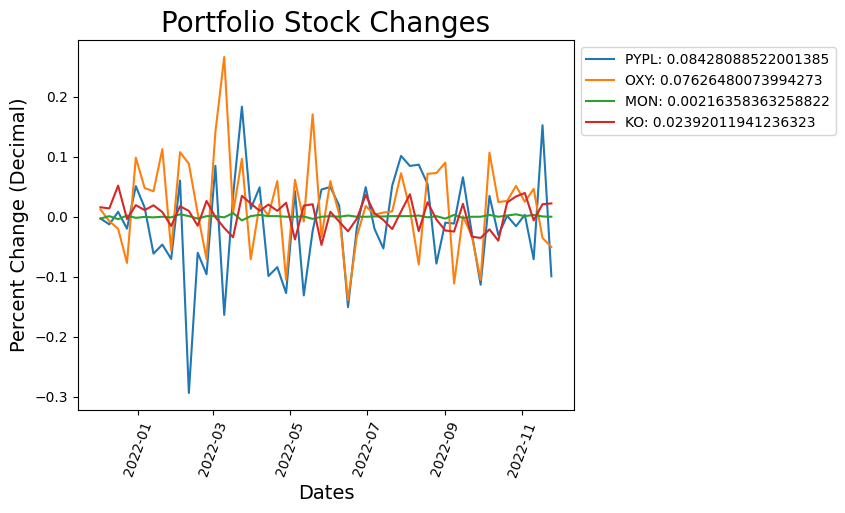

In [244]:
# visualizing the 2 stocks the highest standard deviation and the 2 with the lowest
counter = 0
for x in stockObjects:
    if counter < 2:
        x.graphChange()
        counter = counter+1
        
stockObjects.reverse()

counter = 0
for x in stockObjects:
    if counter < 2:
        x.graphChange()
        counter = counter+1

The graph above shows the percent change of four stocks over time. The stocks displayed above are those with the two highest standard deviations versus the two lowest. We can observe that the two highest standard deviation stocks consistently have greater absolute percent changes than the two stocks with the lowest standard deviation.  

This illustrates our claim that stocks with higher standard deviations, relative to those with lower standard deviations, will generally have percent change of a higher magnitude: supporting our decision to target stocks with high standard deviation for mainstock. 

mainStock Std:  0.08428088522001385
portfolio Std:  0.05039748268486832


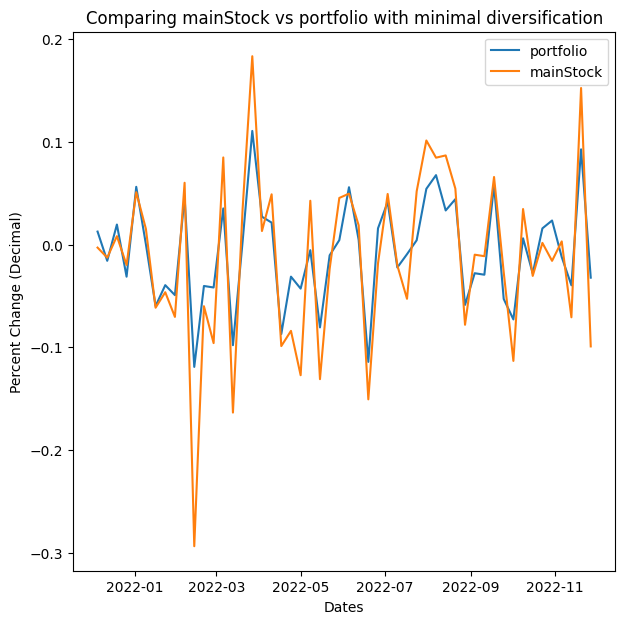

In [245]:
def compare(mainStock, portfolioFinal, portfolioObj):
    '''
    Purpose:
        compares the portfolio's returns to just mainStock's returns
    Inputs:
        portfolioObj (listof Stock): contains a list of Stock objects
        portfolioFinal (dataframe): the dataframe outputed by portfolioFinal function
    output:
        a graph that compares the returns of the portfolio to that of the mainStock
    '''
    temp = pd.DataFrame()
    # initialize the dataframe 
    temp["portfolio"] = portfolioObj[0].companiesDF[portfolioObj[0].ticker]*0

    counter = 0
    for row in portfolioFinal.iterrows():
        # shares * past periods
        temp["portfolio"] += row[1][2]*portfolioObj[counter].companiesDF[portfolioObj[counter].ticker]
        counter += 1
    temp["portfolio"] = temp['portfolio'].pct_change()

    # if entire portfolio is mainStock, we do not need to consider the weighting
    temp['mainStock'] = mainStock.companiesDF[mainStock.ticker].pct_change()
    temp.dropna(inplace=True)

    plt.figure(figsize=(7, 7))
    plt.plot(temp.index, temp["portfolio"], label="portfolio")
    plt.plot(temp.index, temp['mainStock'], label="mainStock")
    plt.legend(loc='best')
    plt.xlabel("Dates")
    plt.ylabel("Percent Change (Decimal)")
    plt.title("Comparing mainStock vs portfolio with minimal diversification")

    print("mainStock Std: ", temp['mainStock'].std())
    print("portfolio Std: ", temp['portfolio'].std())

    plt.show()

compare(mainStock, Portfolio_Final, portfolioObj)

The graph above shows the percent change in value over time of the portfolio, and our “main” (mainStock). Our portfolio adds an additional 11 stocks to the “main”, unfortunately making it more diverse, and less risky. The other two of the three main stocks of the portfolio were those with the highest positive correlation with the “main,” so they are more likely move in the same direction. Given that the weighting of the portfolio was allocated mostly to those three, it tracks that the portfolio would follow the same general trend as the “main” stocks  

Both are quite volatile, although the mainStock has noticeably higher peaks and valleys than the portfolio. Still, structuring our portfolio as described above has preserved the riskiness of investing in just 1 stock, giving it a large spread. The diversifying, and thus, risk-reducing effects of the other 9 stocks have been abated by selecting for higher positive correlation and lowering their weighting; supporting the claim that structuring our portfolio this way would maintain riskiness as much as possible.  

Comparing our Portfolio to another Portfolio with 12 random Stocks


In [246]:
'''
Purpose: Allows you to combine a large amounts of instances
Input: The List, Do you want to have it randomly selected, Amount if Random
Output: An instance of the combination of the stocks in the List
'''
def combineStocks(objList, randomSelect=False, amount=0):
    
    # If random, find a sample
    if randomSelect:
        objList = random.sample(objList, k=amount)
    #Creating the Portfolio
    randomPortfolio = Stock(objList[0].ticker, objList[0].start, objList[0].end)
    objList.pop(0)
    # Adding the Data
    for instance in objList:
        randomPortfolio.companiesDF[randomPortfolio.ticker] += instance.companiesDF[instance.ticker]
    # Updates the pct_Change and the Name
    randomPortfolio.checkValues()
    # Changes name based on if random or not
    if randomSelect:
        randomPortfolio.companiesDF.rename(columns = {randomPortfolio.ticker: 'Random'}, inplace= True)
        randomPortfolio.ticker = 'Random'
    else:
        randomPortfolio.companiesDF.rename(columns = {randomPortfolio.ticker: 'Portfolio'}, inplace= True)
        randomPortfolio.ticker = 'Portfolio'
    return randomPortfolio

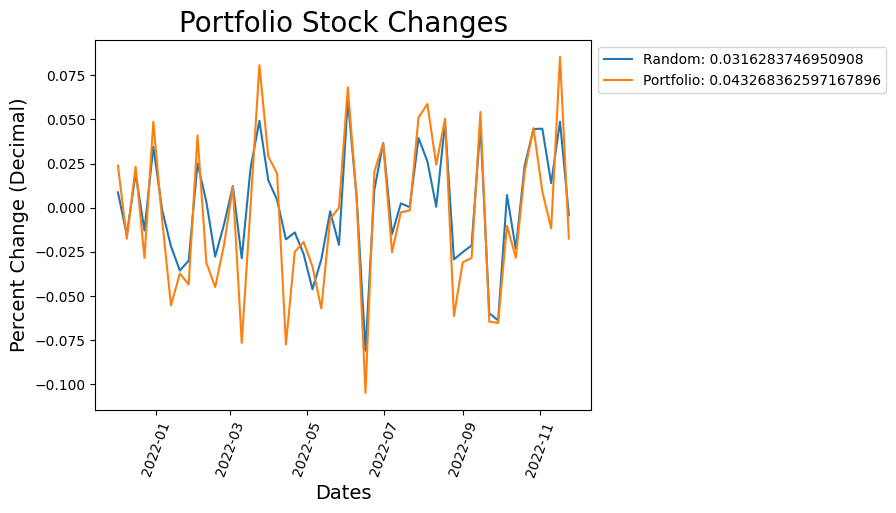

In [247]:
# This code can be run as many times as you wish as the stocks generated are always random
import random

# Creates new portfolios
randomStocks = combineStocks(stockObjects, True, 12)
chosen_portfolio = combineStocks(portfolioObj)

# Graphs the Changes of the Random Portfolio and the Best Portfolio
randomStocks.graphChange()
chosen_portfolio.graphChange()

The graph above is a graph of a portfolio with 12 randomly selected stocks. Due to the random nature of the selection, we note that this portfolio reflects the risk-reducing effects of diversification, with a more limited spread than our portfolio. One crucial test of our portfolio is showing that is it riskier (better) than just picking stocks at random, so we can prove choosing a portfolio our way has some effect. As shown above, our portfolio is more risky than picking stocks randomly, making it a better choice for maximizing risk. (__try running the above code block to see more examples__)

Note: the standard deviation of "Random" is always lower than the standard deviation of "Portfolio" (above)

## Conclusion

Overall, we believe that this portfolio is the riskiest given that we do not know the stocks that will be presented to us. It considers the dynamics of having an unknown input, yet it still calculates the riskiest choice as well as choosing the stocks that have the highest positive correlation with it. 

There were other strategies that we considered: choosing based on a highly volatile industry such as biotech, or Pharmatech, as well as individual stocks and portfolios such as Cathie Wood’s Ark, $TQQQ, TKWY etc. However, these strategies required hardcoding and if the heap of stocks we received did not contain these options, our code would not work.  

Given our calculations and graphs, we have shown the difference between our choice and a random sample of portfolios as well as the difference between each individual stock. They prove that our portfolio is reliable given that the user wants as much risk as possible and betting that they increase.  

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

- Robin: (Signed)
- Jessica: (Signed)
- Eric: (Signed)